Image Processing For TOEIC-OMR-Grading

In [126]:
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [127]:
filename = "template_config.json"
try:
    with open(filename, 'r') as f:
        config = json.load(f)

    print("Cấu hình template đã được tải thành công!")
    print(config)
    bubble_markers_np = np.array(config['bubble_markers'], dtype=np.int32)
    config['x_coords'] = np.array(config['x_coords'], dtype=np.int32)
    config['y_coords'] = np.array(config['y_coords'], dtype=np.int32)

except FileNotFoundError:
    print(f"❌ Lỗi: Không tìm thấy file '{filename}'.")
except Exception as e:
    print(f"❌ Lỗi khi tải hoặc xử lý cấu hình: {e}")

Cấu hình template đã được tải thành công!
{'marker_scaling_ref': 0.041726618705035974, 'warp_size': {'width': 1390, 'height': 897}, 'bubble_markers': [[124, 1, 24, 24], [244, 1, 24, 24], [304, 1, 24, 24], [334, 1, 24, 24], [424, 1, 24, 24], [574, 1, 24, 24], [604, 1, 24, 24], [814, 1, 24, 24]], 'dash_markers': [[2, 158, 27, 10], [2, 189, 27, 9], [2, 218, 27, 9], [2, 248, 27, 10], [2, 279, 27, 9], [2, 309, 27, 9], [2, 338, 27, 9], [2, 368, 27, 10], [2, 398, 27, 10], [2, 429, 27, 9], [2, 458, 27, 9], [2, 488, 27, 10], [2, 519, 27, 9], [2, 549, 27, 9], [2, 578, 27, 9], [2, 608, 27, 9], [2, 638, 27, 10], [2, 669, 27, 9], [2, 698, 27, 9], [2, 728, 27, 10], [2, 759, 27, 9], [2, 789, 27, 9], [2, 818, 27, 9], [2, 848, 27, 9], [2, 879, 27, 9]], 'bubble_radius': 12, 'dash_size': [27, 9], 'x_coords': [135, 165, 195, 225, 285, 315, 345, 375, 435, 465, 495, 525, 585, 615, 645, 675, 795, 825, 855, 885, 945, 975, 1005, 1035, 1095, 1125, 1155, 1185, 1245, 1275, 1305, 1335], 'y_coords': [162, 192, 222,

Size: 1545 x 2000


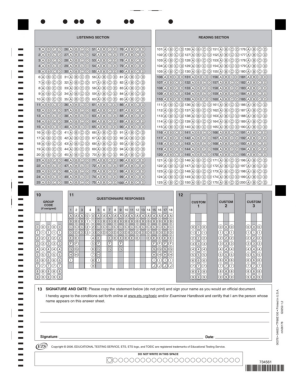

In [128]:
img_path = 'sample2.png' 

img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
if img is None:
    print("Không load được ảnh! Kiểm tra tên file và đường dẫn.")
else:
    print(f"Size: {img.shape[1]} x {img.shape[0]}")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

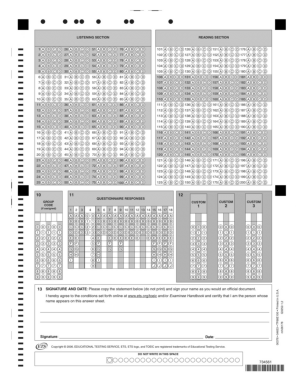

In [129]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
# Hiển thị ảnh grayscale
plt.imshow(img_gray, cmap='gray')
plt.axis('off')
plt.show()

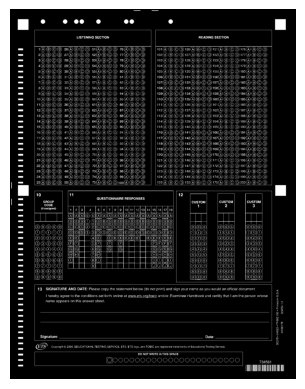

In [130]:
_, img_binary = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY_INV) # BỎ DÒNG NÀY

plt.imshow(img_binary, cmap='gray')
plt.axis('off')
plt.show()

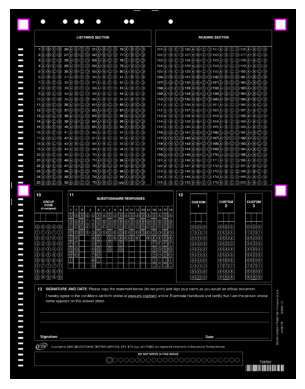

In [131]:
if img_binary is None:
    print("Chưa có ảnh binary!")
else:
    contours, _ = cv2.findContours(img_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    markers = []
    min_size = 0.5 * config['marker_scaling_ref'] * img_binary.shape[1]
    min_density = 0.7  # tối thiểu 70% pixel trắng trong bounding box
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w < min_size or h < min_size:
            continue
        aspect_ratio = w / h
        if not (0.8 <= aspect_ratio <= 1.2):
            continue 
        # Tính density (tỉ lệ pixel trắng)
        roi = img_binary[y:y+h, x:x+w]
        density = np.sum(roi==255) / (w*h)
        if density >= min_density:
            markers.append((x, y, w, h))
    img_display = cv2.cvtColor(img_binary.copy(), cv2.COLOR_GRAY2BGR)
    for (x, y, w, h) in markers:
        cv2.rectangle(img_display, (x, y), (x+w, y+h), (255,0,255), 5)
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

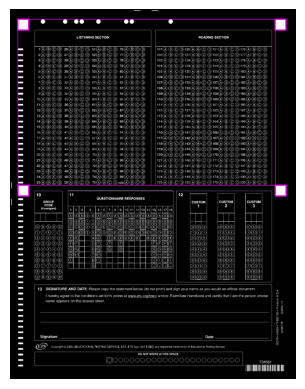

In [132]:
if len(markers) >= 4:
    # a. Sắp xếp 4 marker (sử dụng tâm)
    centers = np.array([[x + w//2, y + h//2] for x, y, w, h in markers])
    s = centers.sum(axis=1)
    diff = np.diff(centers, axis=1)

    tl_idx = np.argmin(s)
    br_idx = np.argmax(s)
    tr_idx = np.argmin(diff)
    bl_idx = np.argmax(diff)

    tl_rect = markers[tl_idx]
    tr_rect = markers[tr_idx]
    br_rect = markers[br_idx]
    bl_rect = markers[bl_idx]

    # b. Trích xuất 4 Tọa độ Góc thực của Phiếu (SRC_POINTS)
    # Tọa độ này sẽ được dùng làm NGUỒN (Source) cho Perspective Warp
    SRC_POINTS = np.float32([
        [tl_rect[0], tl_rect[1]],  # 1. Góc TL của BB TL marker
        [tr_rect[0], tr_rect[1]],  # 2. Góc TL của BB TR marker
        [br_rect[0], br_rect[1]],  # 3. Góc TL của BB BR marker
        [bl_rect[0], bl_rect[1]]   # 4. Góc TL của BB BL marker
    ])

    cv2.polylines(img_display, [np.int32(SRC_POINTS)], True, (255, 0, 255), 2) 
    
else:
    print("⚠️ Không tìm thấy đủ 4 marker lớn để vẽ tứ giác Warp.")
    
plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

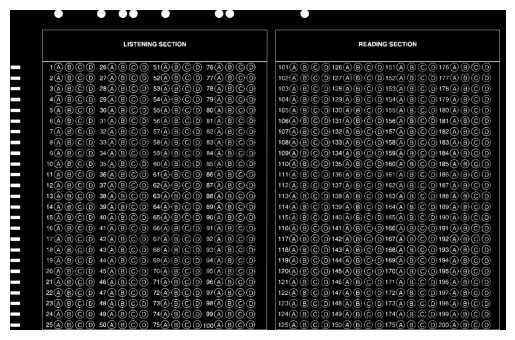

In [133]:
DST_POINTS = np.float32([
    [0, 0],                                                         # Top-Left
    [config['warp_size']['width'], 0],                              # Top-Right
    [config['warp_size']['width'], config['warp_size']['height']],  # Bottom-Right
    [0, config['warp_size']['height']]                              # Bottom-Left
])

  # Tính toán Ma trận biến đổi M
M = cv2.getPerspectiveTransform(SRC_POINTS, DST_POINTS)
# Che phủ marker tl bằng hình chữ nhật ĐẶC màu đen (giá trị 0)
x_tl, y_tl, w_tl, h_tl = tl_rect
cv2.rectangle(img_binary, (int(x_tl), int(y_tl)), (int(x_tl + w_tl), int(y_tl + h_tl)), 0, -1)

# Thực hiện Warp lên ảnh GỐC (img) về kích thước lý tưởng
img_warped = cv2.warpPerspective(img_binary, M, (config['warp_size']['width'], config['warp_size']['height']))

plt.imshow(cv2.cvtColor(img_warped, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

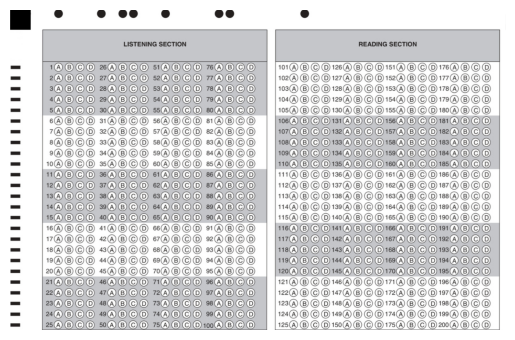

In [134]:
img = cv2.warpPerspective(img, M, (config['warp_size']['width'], config['warp_size']['height']))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

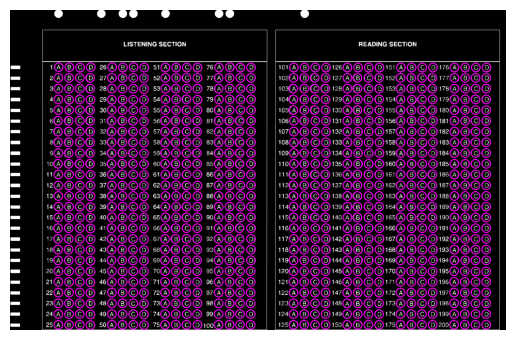

In [ ]:
search_range = 4 # Biên độ tìm kiếm tối đa ±3 pixel
PIXEL_WHITE_THRESHOLD = 200 # Pixel > 200 được coi là "Trắng"
R = config['bubble_radius']
x_coords = np.array(config['x_coords']) 
y_coords = np.array(config['y_coords'])

X_grid, Y_grid = np.meshgrid(x_coords, y_coords)

ideal_bubble_locations = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T.astype(int)
refined_bubble_centers = ideal_bubble_locations.copy() 

# Tạo một mask ĐƯỜNG TRÒN lý tưởng
patch_size = R * 2
ideal_ring_mask = np.zeros((patch_size, patch_size), dtype=np.uint8)
# Vẽ vòng tròn trắng (255) vào tâm mask, độ dày 1px
LINE_THICKNESS = 2
cv2.circle(ideal_ring_mask, (R, R), R, 255, LINE_THICKNESS) 

# 2. THUẬT TOÁN TỐI ƯU HÓA CHU VI (PERIMETER OPTIMIZATION)

for i, (cx_ideal, cy_ideal) in enumerate(ideal_bubble_locations):
    
    max_white_pixels_on_ring = -1 
    best_center = (cx_ideal, cy_ideal)
    
    # Lặp qua cửa sổ tìm kiếm ±3px (7x7 = 49 vị trí)
    for dy in range(-search_range, search_range + 1):
        for dx in range(-search_range, search_range + 1):
            
            cx_test = cx_ideal + dx
            cy_test = cy_ideal + dy
            
            # Trích xuất patch hình vuông (2R x 2R) từ ảnh OMR
            x_start = int(cx_test - R)
            y_start = int(cy_test - R)
            patch = img_warped[y_start:y_start + patch_size, 
                                        x_start:x_start + patch_size]
            
            if patch.shape == ideal_ring_mask.shape:
                
                binary_patch_float = (patch > PIXEL_WHITE_THRESHOLD).astype(np.float32)
                binary_patch_uint8 = (patch > PIXEL_WHITE_THRESHOLD).astype(np.uint8) * 255 
                masked_ring_area = cv2.bitwise_and(binary_patch_uint8, ideal_ring_mask)
                
                # Đếm số lượng pixel trắng trên đường tròn (giá trị > 0)
                current_white_pixels = np.sum(masked_ring_area > 0)
                
                # Cập nhật nếu đây là vị trí chứa nhiều pixel trắng nhất
                if current_white_pixels > max_white_pixels_on_ring:
                    max_white_pixels_on_ring = current_white_pixels
                    best_center = (cx_test, cy_test)
    
    # Lưu lại tâm tối ưu đã tìm được
    refined_bubble_centers[i] = best_center
img_check2 = cv2.cvtColor(img_warped, cv2.COLOR_GRAY2BGR)
for x_final, y_final in refined_bubble_centers:
    center = (x_final, y_final)
    cv2.circle(img_check2, center, R, (255, 0, 255), LINE_THICKNESS) 
plt.imshow(cv2.cvtColor(img_check2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
cv2.imwrite('img_check2.png', img_check2)
import os
os.startfile('img_check2.png') 